# **Notebook Objective**

**Description:**
This notebook investigates the core research question: *How does the
relationship between PM₂.₅ and health outcomes vary across different
levels of socio-demographic development?* We will conduct a
vulnerability analysis by building separate models for each SDI
category. We will also perform a threshold analysis to identify
policy-relevant pollution levels and a sensitivity analysis to ensure
our main conclusions are robust.

### **Setup and Configuration**

**Description:**
This cell imports the necessary libraries and defines the file paths
for the input data and the output directory for figures generated in
this notebook.

In [14]:
# Import necessary libraries
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Define file paths
input_file = Path("../0_datasets/analysis_ready_data.csv")
country_avg_file = Path("../0_datasets/country_level_averages.csv")
model_dir = Path("../4_data_analysis/model_artifacts/")
figure_dir = Path("../4_data_analysis/figures/vulnerability_plots/")

# Ensure the output directory exists
figure_dir.mkdir(parents=True, exist_ok=True)

# Set plotting style
sns.set_theme(style="whitegrid")

### **Load Data**

**Description:**
This cell loads the `analysis_ready_data.csv` created by notebook `01`
and the `country_level_averages.csv` created by notebook `02`. We
perform a quick check to ensure they are loaded correctly.

In [15]:
# Load the main and country-average datasets
df = None
country_avg = None
try:
    df = pd.read_csv(input_file)
    country_avg = pd.read_csv(country_avg_file)
    print("Successfully loaded datasets.")
    print(f"Main data shape: {df.shape}")
    print(f"Country-average data shape: {country_avg.shape}")
except FileNotFoundError:
    print("Error: One or more required data files were not found.")
    print("Please ensure you have run the previous notebooks first.")

# Convert 'SDI_category' to an ordered categorical type for plotting
sdi_order = ["Low", "Medium", "High", "Very High"]
if df is not None and "SDI_category" in df.columns:
    df["SDI_category"] = pd.Categorical(
        df["SDI_category"], categories=sdi_order, ordered=True
    )
if country_avg is not None and "SDI_category" in country_avg.columns:
    country_avg["SDI_category"] = pd.Categorical(
        country_avg["SDI_category"], categories=sdi_order, ordered=True
    )

Successfully loaded datasets.
Main data shape: (1950, 14)
Country-average data shape: (195, 5)


### **Vulnerability Analysis - Modeling by SDI Category**

**Description:**
This cell performs the vulnerability analysis. We test the hypothesis
that less developed nations are more vulnerable to pollution by training
a separate Random Forest model for each SDI category. Each model
predicts `All-cause DALYs` using only PM₂.₅-related features. By
comparing their performance and feature importances, we can assess how
vulnerability changes with development.

In [17]:
# 3.1 Define predictors and target for this analysis
# We exclude SDI itself since we are stratifying by it.
pm_predictor_vars = ["PM2.5", "PM25_lag1", "PM25_lag2", "PM25_3yr_avg", "PM25_5yr_avg"]
target_var = "All-cause DALYs"

# 3.2 Initialize a dictionary to store results
vulnerability_results = {}
sdi_categories = df["SDI_category"].dropna().unique().tolist()

print("--- Building separate models for each SDI Category ---")

for category in sdi_categories:
    print(f"Processing category: {category}")

    # Filter data for the specific SDI category
    category_df = df[df["SDI_category"] == category]

    # Prepare data for modeling
    model_vars = pm_predictor_vars + [target_var]
    model_ready_df = category_df[model_vars].dropna()

    # Skip if there's not enough data
    if model_ready_df.shape[0] < 50:
        print(
            f"  Skipping '{category}' due to insufficient data "
            f"({model_ready_df.shape[0]} samples)."
        )
        continue

    X_cat = model_ready_df[pm_predictor_vars]
    y_cat = model_ready_df[target_var]

    # Train a new Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    # Train on the full category data for importance analysis
    rf_model.fit(X_cat, y_cat)

    # Store results (R-squared on the full data and feature importances)
    r2 = rf_model.score(X_cat, y_cat)
    importances = rf_model.feature_importances_
    vulnerability_results[category] = {
        "R²": r2,
        "Feature Importances": dict(zip(pm_predictor_vars, importances)),
    }
print("--- Vulnerability modeling complete. ---")

--- Building separate models for each SDI Category ---
Processing category: Low
Processing category: High
Processing category: Medium
Processing category: Very High
--- Vulnerability modeling complete. ---


### **Visualize Vulnerability Results**

**Description:**
This cell visualizes the results from the vulnerability analysis. The
first plot compares how well PM₂.₅ features can explain DALYs within
each development group (R²). The second plot shows which specific PM₂.₅
features (current, lagged, or averaged) are most important for each
group.


--- Vulnerability Analysis Results ---


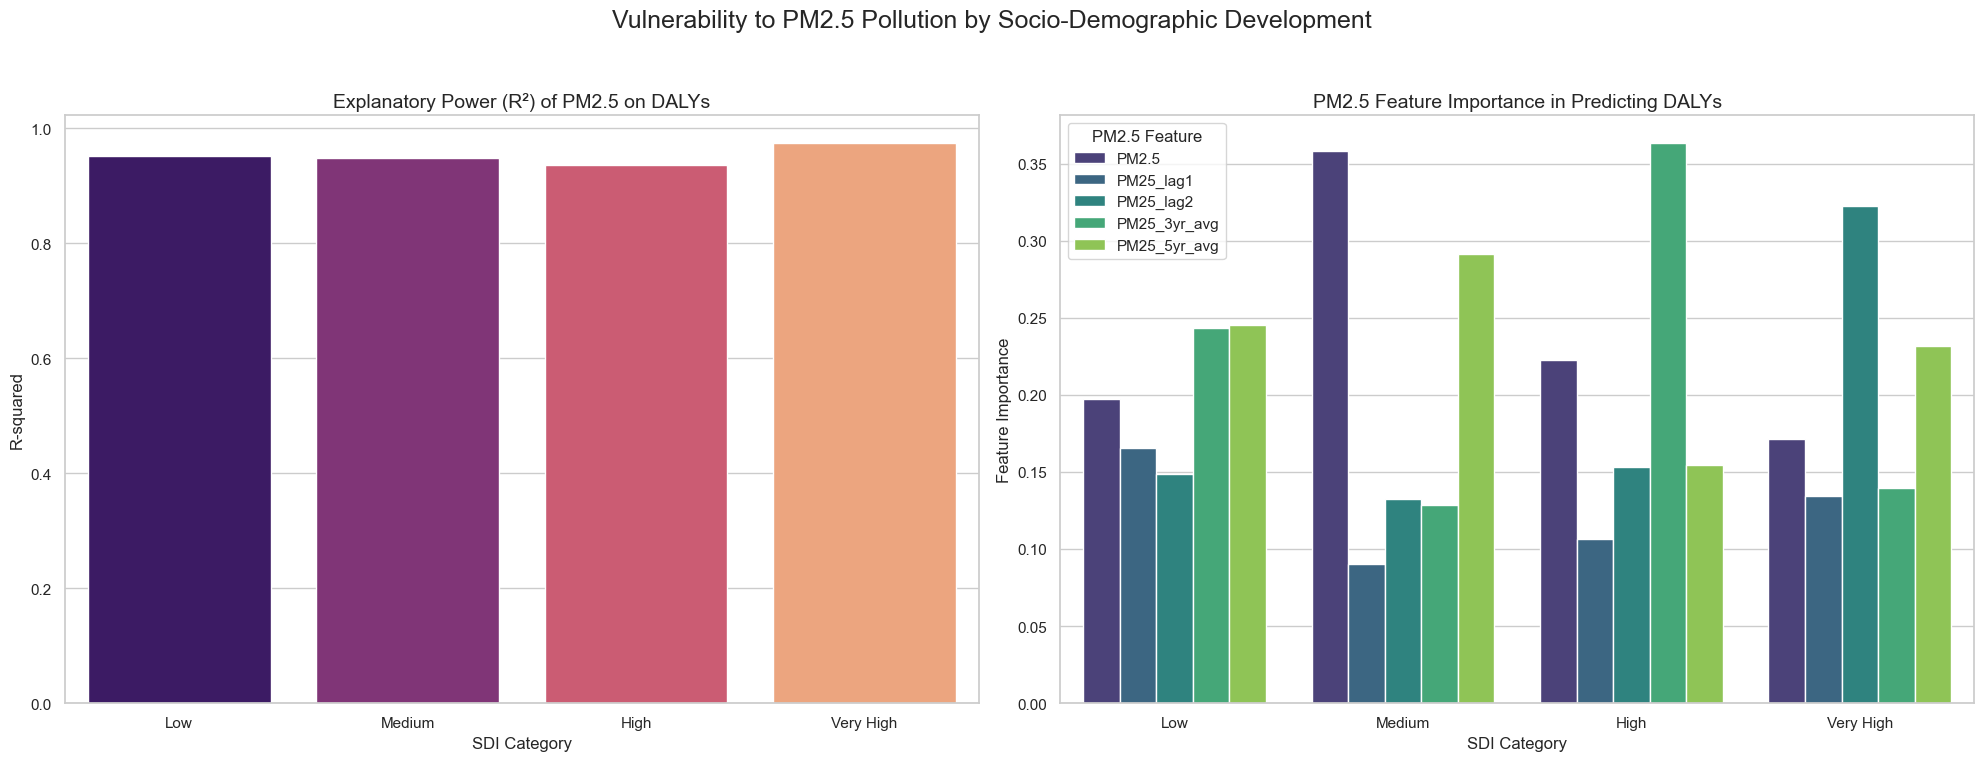

In [19]:
# Create a summary DataFrame for visualization
results_list = []
for category, data in vulnerability_results.items():
    imp_df = pd.DataFrame.from_dict(
        data["Feature Importances"], orient="index", columns=["Importance"]
    )
    imp_df["SDI Category"] = category
    imp_df["R²"] = data["R²"]
    results_list.append(imp_df)

vulnerability_df = (
    pd.concat(results_list).reset_index().rename(columns={"index": "Feature"})
)

# Ensure categorical order for plotting
vulnerability_df["SDI Category"] = pd.Categorical(
    vulnerability_df["SDI Category"],
    categories=["Low", "Medium", "High", "Very High"],
    ordered=True,
)

# Visualize the results
print("\n--- Vulnerability Analysis Results ---")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
title = "Vulnerability to PM2.5 Pollution by " "Socio-Demographic Development"
fig.suptitle(title, fontsize=18)

# Plot 1: R-squared comparison
r2_data = vulnerability_df.drop_duplicates(subset=["SDI Category"])
sns.barplot(
    data=r2_data,
    x="SDI Category",
    y="R²",
    hue="SDI Category",
    palette="magma",
    ax=axes[0],
    legend=False,
)
axes[0].set_title("Explanatory Power (R²) of PM2.5 on DALYs", fontsize=14)
axes[0].set_ylabel("R-squared")
axes[0].set_ylim(bottom=0)

# Plot 2: Feature Importance comparison
sns.barplot(
    data=vulnerability_df,
    x="SDI Category",
    y="Importance",
    hue="Feature",
    palette="viridis",
    ax=axes[1],
)
axes[1].set_title("PM2.5 Feature Importance in Predicting DALYs", fontsize=14)
axes[1].set_ylabel("Feature Importance")
axes[1].legend(title="PM2.5 Feature")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(figure_dir / "fig_08_vulnerability_analysis.png")
plt.show()

### **Policy-Relevant Threshold Analysis**

**Description:**
This step aims to identify a potential "tipping point" in PM₂.₅
concentrations where the impact on health outcomes becomes significantly
more severe. We use a threshold (the global median PM₂.₅ value) and
visualize how the DALY burden differs for countries above and below this
threshold within each SDI category.

--- Policy-Relevant Threshold Analysis ---
Using a PM2.5 threshold of: 18.98 µg/m³ (global median)


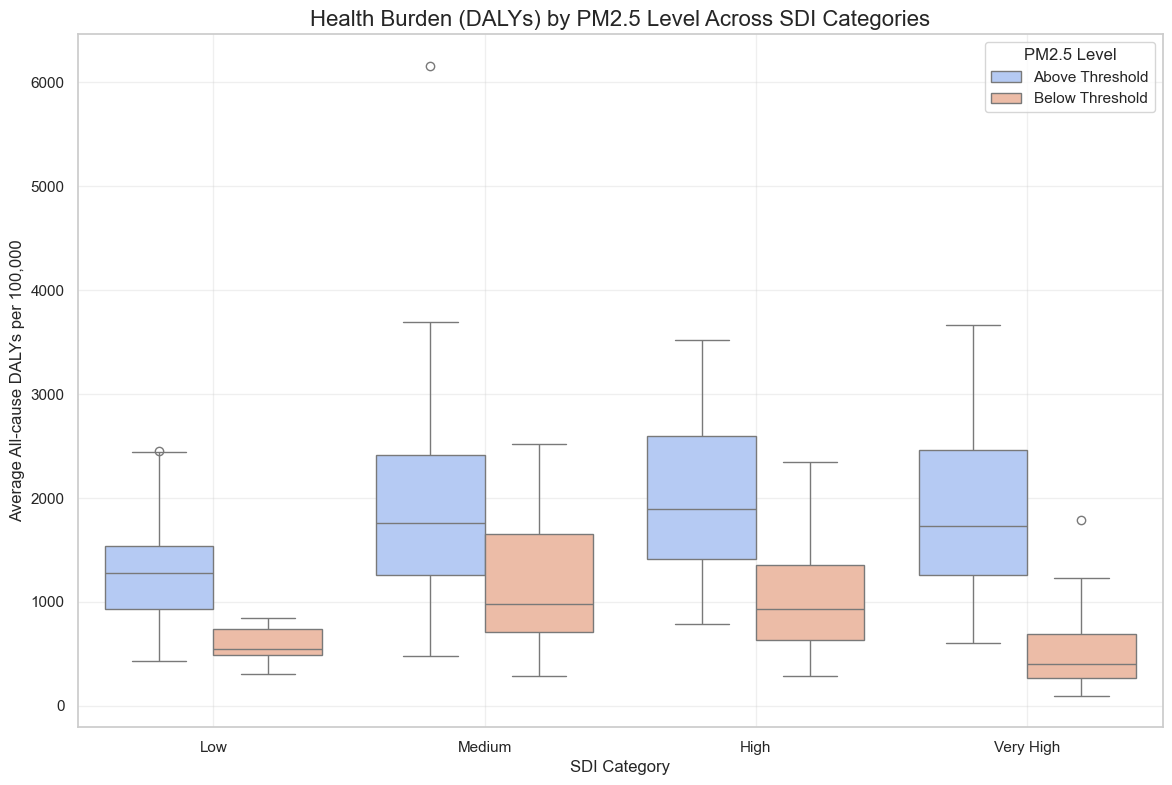

In [21]:
# Define a PM2.5 threshold
pm25_threshold = country_avg["PM2.5"].median()
print("--- Policy-Relevant Threshold Analysis ---")
print(f"Using a PM2.5 threshold of: {pm25_threshold:.2f} µg/m³ " f"(global median)")


# Create a categorical variable based on the threshold
def categorize_pm_level(x):
    if x > pm25_threshold:
        return "Above Threshold"
    else:
        return "Below Threshold"


country_avg["PM25_Level"] = country_avg["PM2.5"].apply(categorize_pm_level)

# Visualize DALYs above and below the threshold, stratified by SDI
plt.figure(figsize=(14, 9))
sns.boxplot(
    data=country_avg,
    x="SDI_category",
    y="All-cause DALYs",
    hue="PM25_Level",
    palette="coolwarm",
    order=["Low", "Medium", "High", "Very High"],
)
plt.title("Health Burden (DALYs) by PM2.5 Level Across SDI Categories", fontsize=16)
plt.xlabel("SDI Category")
plt.ylabel("Average All-cause DALYs per 100,000")
plt.legend(title="PM2.5 Level")
plt.grid(True, alpha=0.3)
plt.savefig(figure_dir / "fig_09_threshold_analysis.png")
plt.show()

### **Model Sensitivity Analysis**

**Description:**
This final analysis checks the robustness of our findings. We retrain
the main Random Forest model using different subsets of features (e.g.,
without lags, with only current PM₂.₅). This helps confirm that our key
conclusions, especially the overwhelming importance of SDI, are
consistent and not just an artifact of a specific model configuration.

In [ ]:
# Define feature sets for sensitivity testing
print("\n--- Model Sensitivity Analysis ---")
print("Retraining models with different feature sets to check for " "robustness...")

feature_sets = {
    "Full Model (from notebook 03)": [
        "PM2.5",
        "SDI",
        "PM25_lag1",
        "PM25_lag2",
        "PM25_3yr_avg",
        "PM25_5yr_avg",
        "PM25_SDI_interaction",
    ],
    "No Lag/Avg Features": ["PM2.5", "SDI", "PM25_SDI_interaction"],
    "Current PM2.5 & SDI Only": ["PM2.5", "SDI"],
}

sensitivity_results = {}
target_var = "All-cause DALYs"

for set_name, predictors in feature_sets.items():
    # Prepare data
    model_data = df[predictors + [target_var]].dropna()
    X_sens = model_data[predictors]
    y_sens = model_data[target_var]
    X_train, X_test, y_train, y_test = train_test_split(
        X_sens, y_sens, test_size=0.2, random_state=42
    )

    # Train model and evaluate
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1).fit(
        X_train, y_train
    )
    r2 = r2_score(y_test, rf.predict(X_test))
    importances = pd.Series(rf.feature_importances_, index=predictors)
    sensitivity_results[set_name] = {"R²": r2, "Importances": importances}

# Display sensitivity results
print("\n--- Sensitivity Analysis Results ---")
for set_name, results in sensitivity_results.items():
    print(f"\nModel: {set_name}")
    print(f"  R²: {results['R²']:.4f}")
    print("  Feature Importances:")
    display(
        results["Importances"].sort_values(ascending=False).to_frame(name="Importance")
    )


--- Model Sensitivity Analysis ---
Retraining models with different feature sets to check for robustness...

--- Sensitivity Analysis Results ---

Model: Full Model (from notebook 03)
  R²: 0.7883
  Feature Importances:


,Importance
PM25_SDI_interaction,0.487327
SDI,0.246783
PM2.5,0.077923
PM25_5yr_avg,0.054228
PM25_lag2,0.049565
PM25_lag1,0.045420
PM25_3yr_avg,0.038754



Model: No Lag/Avg Features
  R²: 0.7137
  Feature Importances:


,Importance
PM25_SDI_interaction,0.530741
SDI,0.296948
PM2.5,0.172311



Model: Current PM2.5 & SDI Only
  R²: 0.7101
  Feature Importances:


,Importance
PM2.5,0.578941
SDI,0.421059
